In [3]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from PIL import Image
# from torchvision.transforms import ToTensor, ToPILImage
# import numpy as np

# # --- 1. Configuration ---
# IMAGE_PATH = 'target.jpg'  # Put a small image here (e.g., 128x128)
# STEPS = 5000
# LR = 1e-3
# HIDDEN_SIZE = 256
# LAYERS = 4

# # --- 2. Data Preparation ---
# def get_image_data(path):
#     img = Image.open(path).convert('RGB')
#     # Resize to something small for speed if needed
#     img = img.resize((128, 128))
#     tensor_img = ToTensor()(img) # Shape: [3, H, W]
#     return tensor_img

# target_img = get_image_data(IMAGE_PATH)
# c, h, w = target_img.shape

# # Create Coordinate Grid (Inputs: x, y)
# # We map coordinates to range [-1, 1] for better training stability
# x_coords = torch.linspace(-1, 1, w)
# y_coords = torch.linspace(-1, 1, h)
# grid_y, grid_x = torch.meshgrid(y_coords, x_coords, indexing='ij')

# # Flatten inputs and targets
# # Inputs: [H*W, 2] -> (x, y) for every pixel
# inputs = torch.stack([grid_x, grid_y], dim=-1).reshape(-1, 2)
# # Targets: [H*W, 3] -> (r, g, b) for every pixel
# targets = target_img.permute(1, 2, 0).reshape(-1, 3)

# # --- 3. The Model (MLP) ---
# class NeuralPainter(nn.Module):
#     def __init__(self):
#         super().__init__()
#         layers = []
#         # Input is 2 (x, y)
#         layers.append(nn.Linear(2, HIDDEN_SIZE))
#         layers.append(nn.ReLU())

#         for _ in range(LAYERS):
#             layers.append(nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE))
#             layers.append(nn.ReLU())

#         # Output is 3 (r, g, b)
#         layers.append(nn.Linear(HIDDEN_SIZE, 3))
#         layers.append(nn.Sigmoid()) # Forces output to be between 0 and 1 (valid colors)

#         self.net = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.net(x)

# model = NeuralPainter()
# optimizer = optim.Adam(model.parameters(), lr=LR)
# criterion = nn.MSELoss()

# # --- 4. Training ---
# print(f"Training on {h}x{w} image...")

# for step in range(STEPS):
#     optimizer.zero_grad()

#     # Predict colors for all coordinates
#     outputs = model(inputs)

#     # Calculate loss against actual pixel colors
#     loss = criterion(outputs, targets)

#     loss.backward()
#     optimizer.step()

#     if step % 500 == 0:
#         print(f"Step {step}, Loss: {loss.item():.6f}")

# # --- 5. Visualization ---
# with torch.no_grad():
#     predicted_pixels = model(inputs)
#     # Reshape back to image format [C, H, W]
#     reconstructed = predicted_pixels.reshape(h, w, 3).permute(2, 0, 1)

#     # Save result
#     ToPILImage()(reconstructed).save('day9_result.png')
#     print("Saved reconstruction to 'day9_result.png'")

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision.transforms import ToTensor
import requests
from io import BytesIO


url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
#resizing to 100x100
img = img.resize((100,100))

#2 Convert to numbers( tensor )
target_tensor = ToTensor()(img)
print("Success")
print(f"Image Shape : {target_tensor.shape}")

Success
Image Shape : torch.Size([3, 100, 100])


In [5]:
c,h,w = target_tensor.shape
#getting the dimensions

# create the rulers for x and y axis
x_axis = torch.linspace(-1,1,w)
y_axis = torch.linspace(-1,1,h)

grid_y, grid_x = torch.meshgrid(y_axis, x_axis, indexing ='ij' )
#4 Combine them into pairs
# this Creates a list of pairs : [(-1,-1),(-1,-0.9)....(1,1)]
inputs = torch.stack([grid_x,grid_y], dim = -1)

#5 Flatten it
# tye network expects a long list of points , not a square grid
# reshape to {total pixesl m 2}
inputs = inputs.reshape(-1,2)
print(f"Inputs shape : {inputs.shape}")


Inputs shape : torch.Size([10000, 2])


In [6]:
#convert Image pixels' rgb to tensor of [10000,3]
target_flat = target_tensor.permute(1,2,0)
# squash 100*100 = 10000
target_flat = target_flat.reshape(-1,3)
print(f"Target shape : {target_flat.shape}")

Target shape : torch.Size([10000, 3])


In [7]:
class NeuralPainter(nn.Module):
    def __init__(self):
        super().__init__()
        # Use HIDDEN_SIZE and LAYERS from the initial setup
        hidden_size = 256 # From the initial setup (uZMA3EtMasoJ)
        num_layers = 4    # From the initial setup (uZMA3EtMasoJ)

        layers = []
        # Input is 2 (x, y)
        layers.append(nn.Linear(2, hidden_size))
        layers.append(nn.ReLU())

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        # Output is 3 (r, g, b)
        layers.append(nn.Linear(hidden_size, 3))
        layers.append(nn.Sigmoid()) # Forces output to be between 0 and 1 (valid colors)

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

#Create the robot
model = NeuralPainter()
print(model)

NeuralPainter(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=3, bias=True)
    (9): Sigmoid()
  )
)


In [8]:
#torch.optim is the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)
#2 Setup Grading System (loss)
criterion = nn.MSELoss()

#train for 2000 steps
print("training started...")
for step in range(2001):
  # A reset Gradients ( standard pytorch boilerplate)
  optimizer.zero_grad()

  #b Ask the students to guess colpurs for all coordinates
  guesses = model(inputs)

  #c compare guesses to acutal answers
  loss = criterion(guesses, target_flat)
  # Backpropagation by finding out which neuron made mistakes
  loss.backward()
  # update weights

  optimizer.step()

  if step % 10 == 0:
    print(f"step {step} , Error (loss): {loss.item():.5f}")

training started...
step 0 , Error (loss): 0.11091
step 10 , Error (loss): 0.08023
step 20 , Error (loss): 0.05313
step 30 , Error (loss): 0.03327
step 40 , Error (loss): 0.02285
step 50 , Error (loss): 0.01864
step 60 , Error (loss): 0.01556
step 70 , Error (loss): 0.01339
step 80 , Error (loss): 0.01192
step 90 , Error (loss): 0.01031
step 100 , Error (loss): 0.00934
step 110 , Error (loss): 0.00863
step 120 , Error (loss): 0.00808
step 130 , Error (loss): 0.00794
step 140 , Error (loss): 0.00767
step 150 , Error (loss): 0.00731
step 160 , Error (loss): 0.00720
step 170 , Error (loss): 0.00646
step 180 , Error (loss): 0.00620
step 190 , Error (loss): 0.00736
step 200 , Error (loss): 0.00585
step 210 , Error (loss): 0.00580
step 220 , Error (loss): 0.00550
step 230 , Error (loss): 0.00537
step 240 , Error (loss): 0.00589
step 250 , Error (loss): 0.00551
step 260 , Error (loss): 0.00497
step 270 , Error (loss): 0.00493
step 280 , Error (loss): 0.00494
step 290 , Error (loss): 0.00557
s

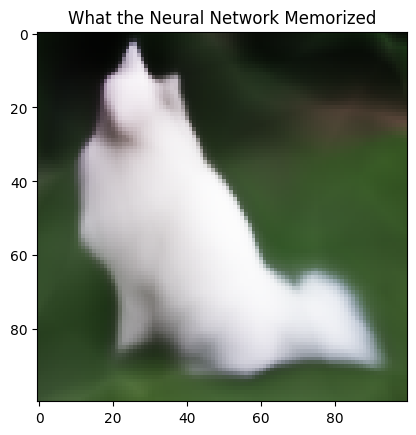

In [9]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

# 1. Ask the model for the final image
with torch.no_grad():
    # Get all guesses
    final_guesses = model(inputs) # Shape: [10000, 3]
    
    # 2. Reshape back to a square: [100, 100, 3]
    reconstructed_img = final_guesses.reshape(h, w, 3)
    
    # 3. Swap dimensions to PyTorch format: [3, 100, 100]
    # Height (0), Width (1), Channels (2) -> Channels (2), Height (0), Width (1)
    final_tensor = reconstructed_img.permute(2, 0, 1)

# 4. Show the result
result_img = ToPILImage()(final_tensor)
plt.imshow(result_img)
plt.title("What the Neural Network Memorized")
plt.show()

# Optional: Save it
result_img.save("day9_output.png")